In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf

from pyspark.ml.stat import Correlation

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

from pyspark.ml.feature import Bucketizer, StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import RegressionEvaluator
%matplotlib inline


In [5]:
outbreaks = pd.read_csv("outbreaks.csv")
outbreaks.head(10)

,Year,Month,State,Location,Food,Ingredient,Species,Serotype/Genotype,Status,Illnesses,Hospitalizations,Fatalities
0,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,20,0.0,0.0
1,1998,January,California,NaN,Custard,NaN,NaN,NaN,NaN,112,0.0,0.0
2,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,35,0.0,0.0
3,1998,January,California,Restaurant,"Fish, Ahi",NaN,Scombroid toxin,NaN,Confirmed,4,0.0,0.0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",NaN,Salmonella enterica,Enteritidis,Confirmed,26,3.0,0.0
5,1998,January,California,Restaurant,NaN,NaN,Shigella boydii,NaN,Confirmed,25,3.0,0.0
6,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,8,0.0,0.0
7,1998,January,California,Restaurant,"Stuffing, Unspecified; Sandwich, Turkey",NaN,Salmonella enterica,Enteritidis,Confirmed,4,3.0,0.0
8,1998,January,Colorado,Restaurant,"Salad, Unspecified",NaN,Virus,NaN,Suspected,21,NaN,NaN
9,1998,January,Colorado,Restaurant,"Peppers, Chili",NaN,Virus,NaN,Suspected,3,NaN,0.0


In [6]:
#check stats
#Null values for ingredients and serotype/genotype has been high
outbreaks.isnull().sum()

Year                     0
Month                    0
State                    0
Location              2166
Food                  8963
Ingredient           17243
Species               6619
Serotype/Genotype    15212
Status                6619
Illnesses                0
Hospitalizations      3625
Fatalities            3601
dtype: int64

In [7]:
#Overall records in the dataset are 19119 which are very almost close to null values in Ingredient and Serotype,
#so, we shouldn't consider these values as it might mislead us, its mentioned below too

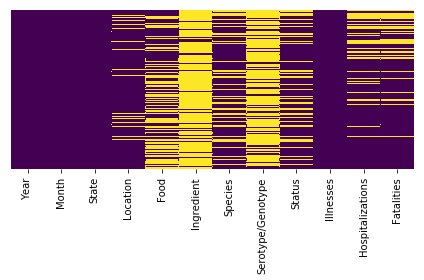

In [8]:
plt.cla()
sns.heatmap(outbreaks.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
display()

In [9]:
outbreaks =outbreaks.rename(index=str, columns={"Serotype/Genotype": "Serotype"})

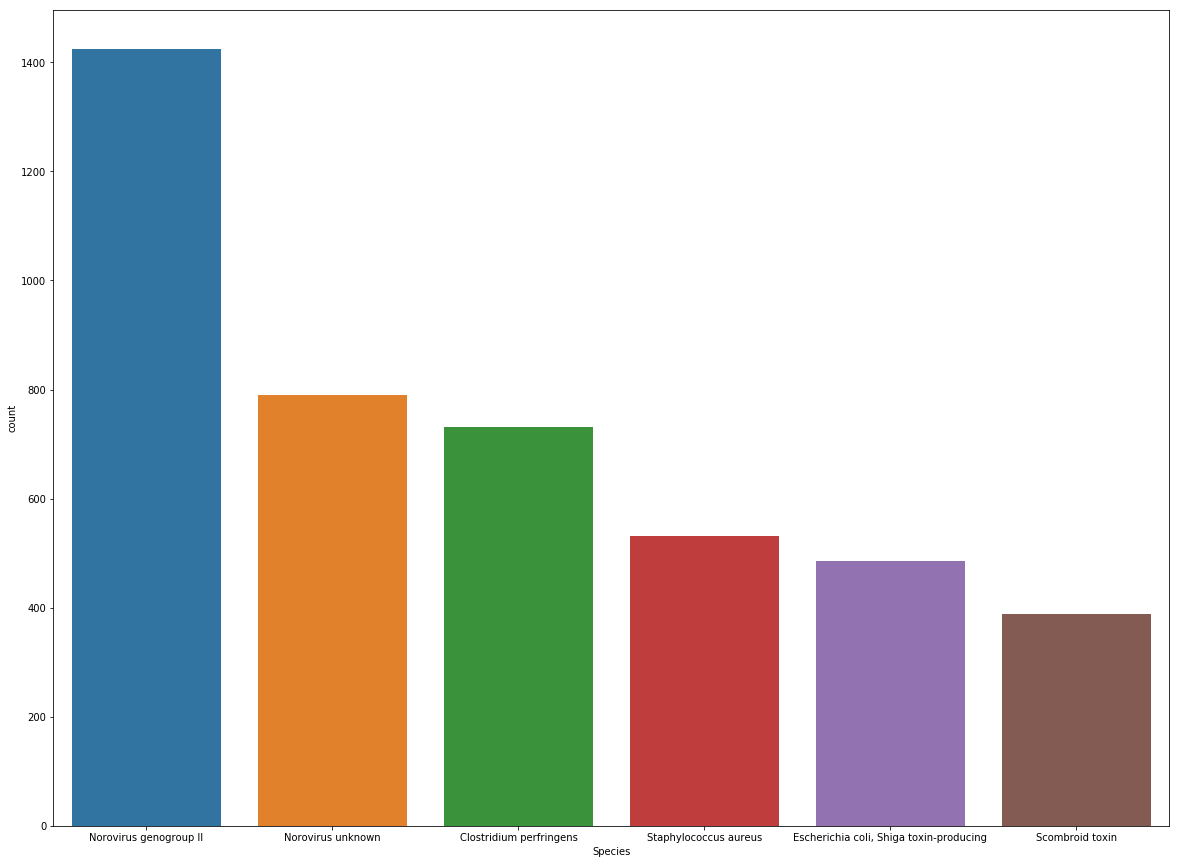

In [10]:
plt.subplots(figsize=(20,15))
sns.countplot(x='Species', data=outbreaks, order= outbreaks.Species.value_counts().iloc[2:8].index)
display()

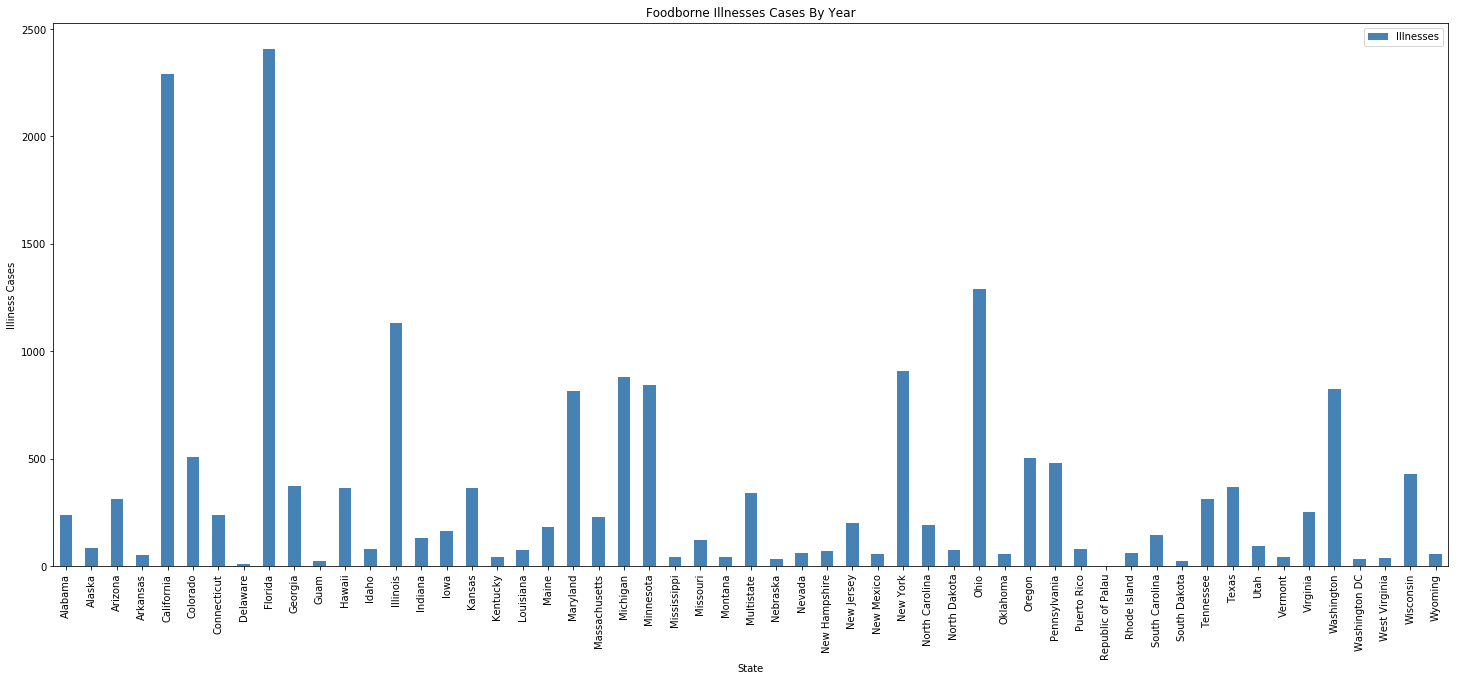

In [13]:

df2 = pd.pivot_table(outbreaks, index='State', values='Illnesses', aggfunc='count')
ax = df2.plot(kind='bar', color='steelblue',figsize=(25,10))
plt.title('Foodborne Illnesses Cases By Year')
plt.ylabel('Illiness Cases')
display()

In [14]:
outbreaks.Food.value_counts()

Multiple Foods                                                             206
Oysters, Raw                                                               165
Ground Beef, Hamburger                                                     127
Salad, Unspecified                                                         118
Chicken, Unspecified                                                       105
Sandwich, Submarine                                                         85
Chicken, Other                                                              83
Pizza, Unspecified                                                          81
Lettuce-Based Salads Unspecified                                            81
Pork, Bbq                                                                   80
Fish, Mahi Mahi                                                             78
Tuna, Unspecified                                                           72
Pizza, Meat                                         

In [15]:
outbreaks.drop(['Ingredient', 'Serotype', 'Species', 'Status', 'Fatalities'], axis=1, inplace=True)
outbreaks.head()

,Year,Month,State,Location,Food,Illnesses,Hospitalizations
0,1998,January,California,Restaurant,NaN,20,0.0
1,1998,January,California,NaN,Custard,112,0.0
2,1998,January,California,Restaurant,NaN,35,0.0
3,1998,January,California,Restaurant,"Fish, Ahi",4,0.0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",26,3.0


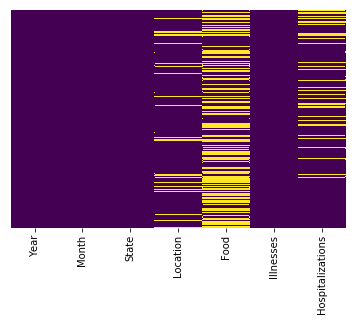

In [16]:
plt.cla()
sns.heatmap(outbreaks.isnull(), yticklabels=False, cbar=False, cmap='viridis')
display()

In [17]:
#Checking Null values in location
outbreaks.isnull().sum()

Year                   0
Month                  0
State                  0
Location            2166
Food                8963
Illnesses              0
Hospitalizations    3625
dtype: int64

In [18]:
#Checking count of values in dataset
outbreaks.count()

Year                19119
Month               19119
State               19119
Location            16953
Food                10156
Illnesses           19119
Hospitalizations    15494
dtype: int64

c:\users\handa\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


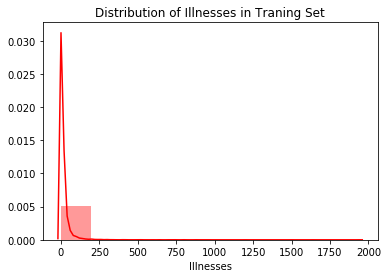

In [19]:
#How illnesses are distributed over dataset
plt.cla()
sns.distplot(outbreaks.Illnesses, bins=10, color='red')
plt.title('Distribution of Illnesses in Traning Set')
display()

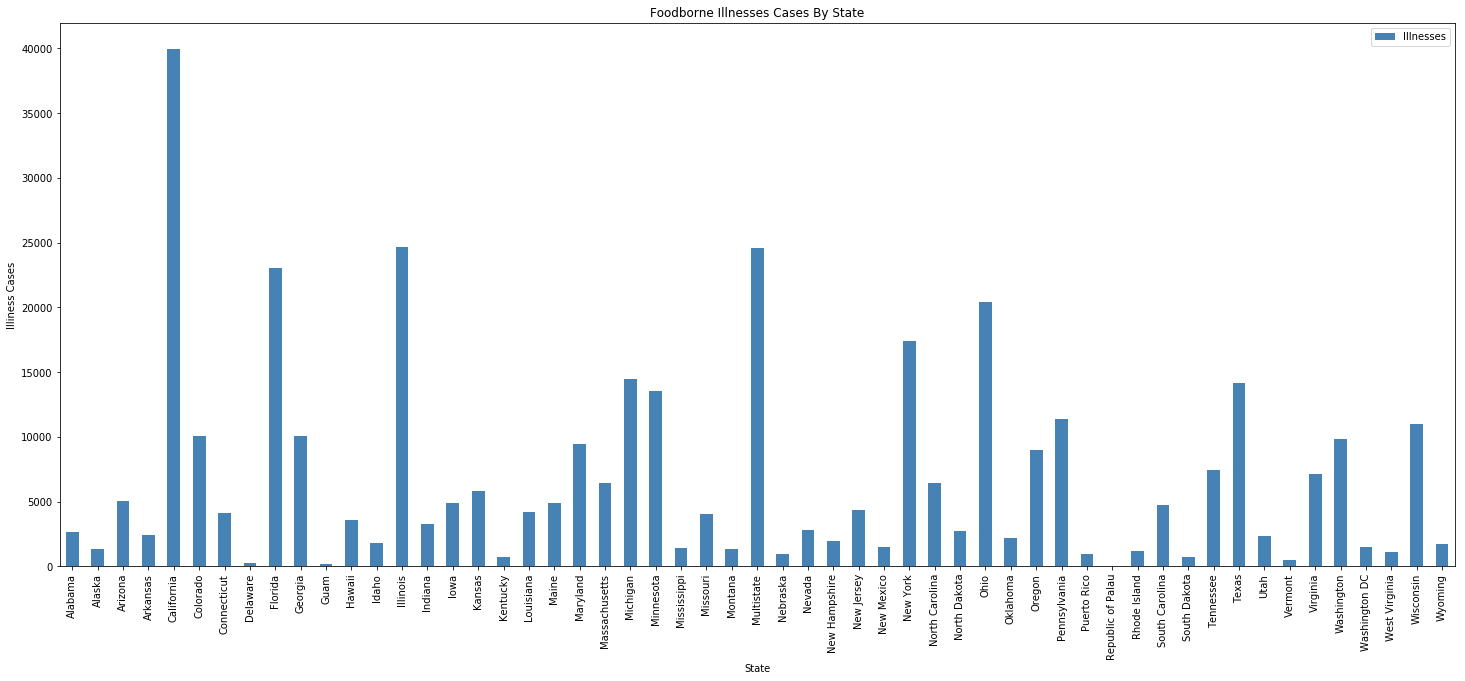

In [22]:
#Distribution of FoodBorne Illnesses by State
df2 = pd.pivot_table(outbreaks, index='State', values='Illnesses', aggfunc='sum')
ax = df2.plot(kind='bar', color='steelblue',figsize=(25,10))
plt.title('Foodborne Illnesses Cases By State')
plt.ylabel('Illiness Cases')
display()

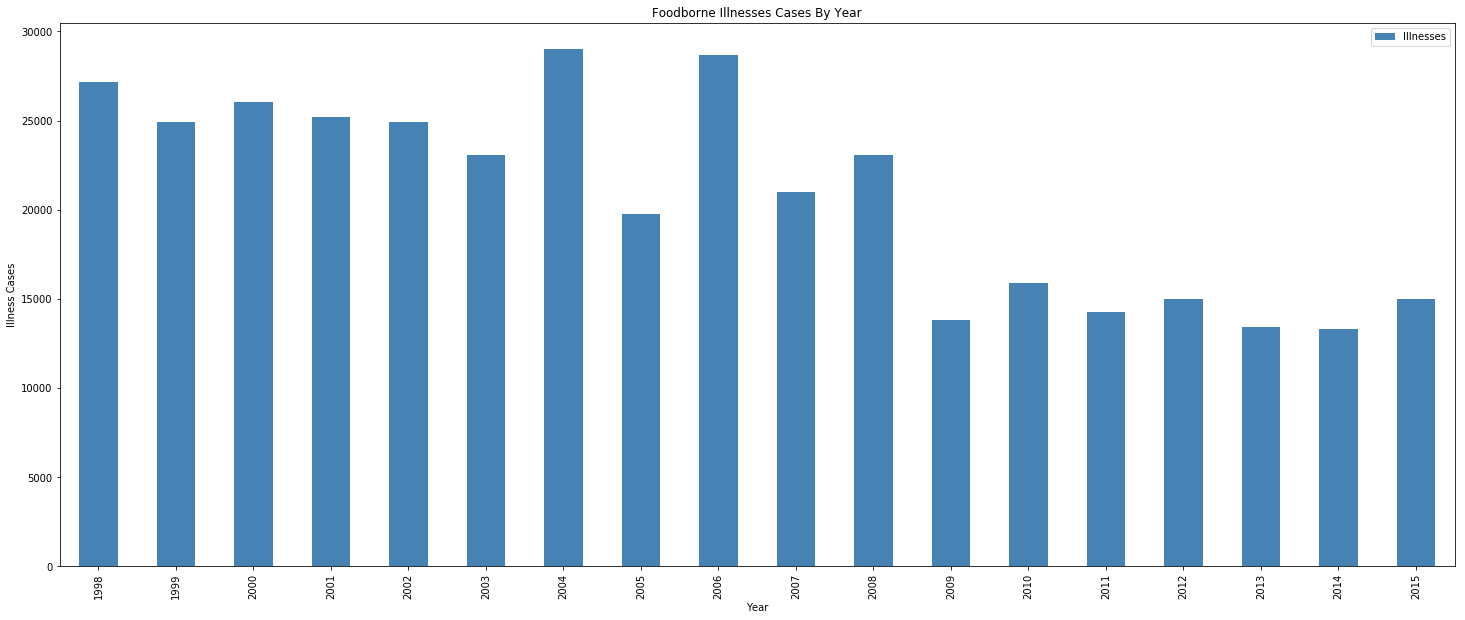

In [23]:
#Distribution of FoodBorne Illnesses by Year
df2 = pd.pivot_table(outbreaks, index='Year', values='Illnesses', aggfunc='sum')
ax = df2.plot(kind='bar', color='steelblue',figsize=(25,10))
plt.title('Foodborne Illnesses Cases By Year')
plt.ylabel('Illness Cases')
display()

Text(0,0.5,'Illiness Cases')

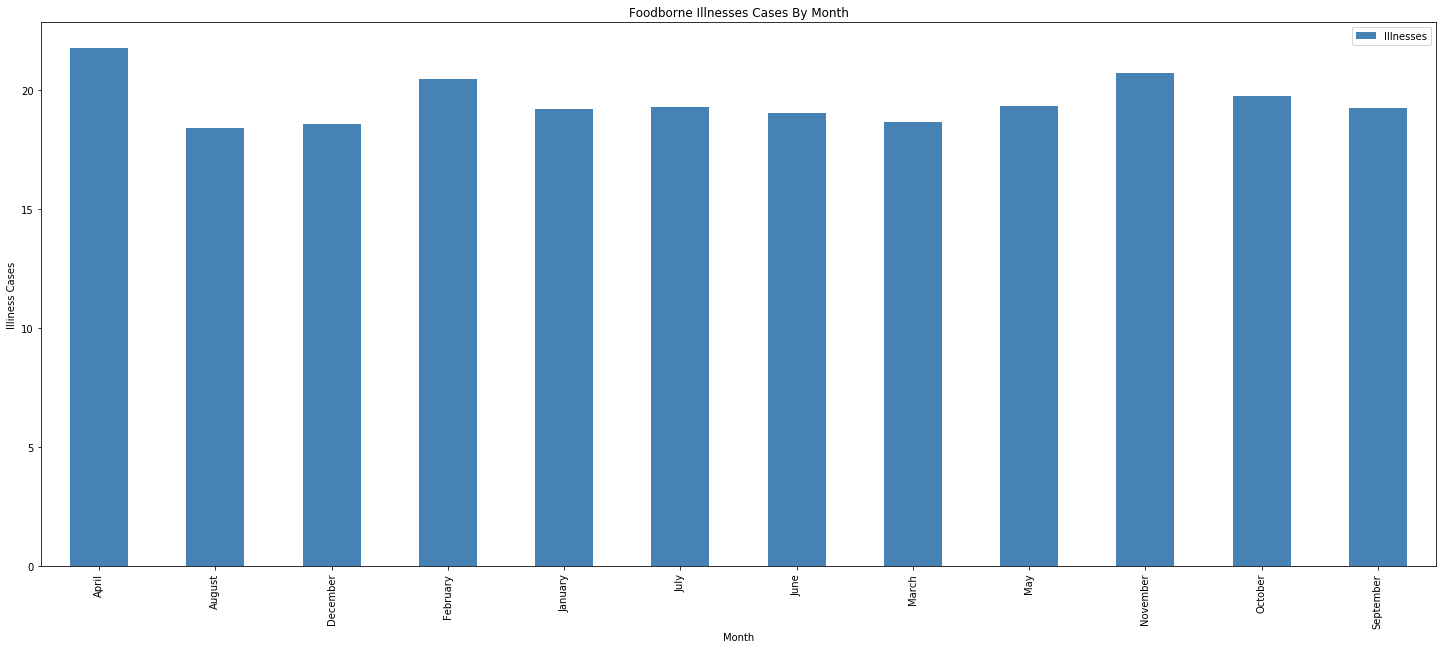

In [25]:
#Distribution of illness by Months
df2 = pd.pivot_table(outbreaks, index='Month', values='Illnesses', aggfunc='mean')
ax = df2.plot(kind='bar', color='steelblue',figsize=(25,10))
plt.title('Foodborne Illnesses Cases By Month')
plt.ylabel('Illiness Cases')

In [26]:
#Checking top food items
outbreaks.Food.value_counts()

Multiple Foods                                                             206
Oysters, Raw                                                               165
Ground Beef, Hamburger                                                     127
Salad, Unspecified                                                         118
Chicken, Unspecified                                                       105
Sandwich, Submarine                                                         85
Chicken, Other                                                              83
Pizza, Unspecified                                                          81
Lettuce-Based Salads Unspecified                                            81
Pork, Bbq                                                                   80
Fish, Mahi Mahi                                                             78
Tuna, Unspecified                                                           72
Pizza, Meat                                         

In [27]:
#Filling null values of food column with "Unspecified"

In [28]:
outbreaks.Food.fillna("Unspecified", inplace=True)
outbreaks.Location.fillna("Unknown", inplace=True)
outbreaks.Location.value_counts()


Restaurant                                                                                  10448
Unknown                                                                                      2521
Private Home/Residence                                                                       1681
Catering Service                                                                             1089
Banquet Facility                                                                              367
Fast Food Restaurant                                                                          366
School/College/University                                                                     354
Grocery Store                                                                                 301
Restaurant; Private Home/Residence                                                            205
Prison/Jail                                                                                   193
Nursing Home/Assiste

In [29]:
#Filling Hospitalizations Null value with 0
outbreaks.Hospitalizations.fillna(0, inplace=True)

In [30]:
#Creating Normalized Column for Hospitalizations/Illnesses

In [31]:
outbreaks['normalized_hospitalizations'] = outbreaks.apply(lambda row: round((row.Hospitalizations/row.Illnesses)*100), axis=1)

c:\users\handa\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


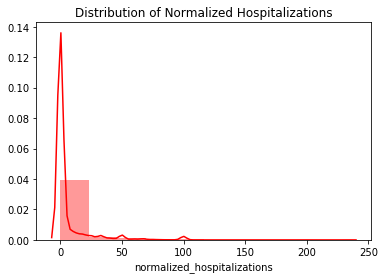

In [32]:
#How Normalized Hospitalizations are distributed over dataset
plt.cla()
sns.distplot(outbreaks.normalized_hospitalizations, bins=10, color='red')
plt.title('Distribution of Normalized Hospitalizations')
display()

In [33]:
outbreaks.head(5)

,Year,Month,State,Location,Food,Illnesses,Hospitalizations,normalized_hospitalizations
0,1998,January,California,Restaurant,Unspecified,20,0.0,0
1,1998,January,California,Unknown,Custard,112,0.0,0
2,1998,January,California,Restaurant,Unspecified,35,0.0,0
3,1998,January,California,Restaurant,"Fish, Ahi",4,0.0,0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",26,3.0,12


c:\users\handa\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


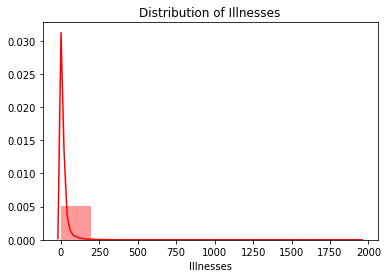

In [34]:
plt.cla()
sns.distplot(outbreaks.Illnesses, bins=10, color='red')
plt.title('Distribution of Illnesses')
display()

c:\users\handa\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


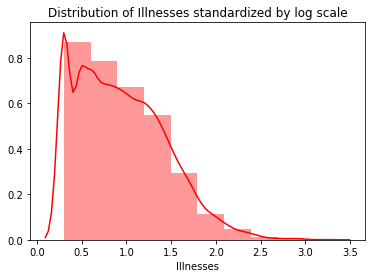

In [35]:
plt.cla()
sns.distplot(np.log10(outbreaks.Illnesses), bins=10, color='red')
plt.title('Distribution of Illnesses standardized by log scale')
display()

In [36]:
#Adding new column log- illness on our data

In [37]:
outbreaks['Illnesses_log'] = np.log(outbreaks.Illnesses)

In [38]:
outbreaks.head()

,Year,Month,State,Location,Food,Illnesses,Hospitalizations,normalized_hospitalizations,Illnesses_log
0,1998,January,California,Restaurant,Unspecified,20,0.0,0,2.995732
1,1998,January,California,Unknown,Custard,112,0.0,0,4.718499
2,1998,January,California,Restaurant,Unspecified,35,0.0,0,3.555348
3,1998,January,California,Restaurant,"Fish, Ahi",4,0.0,0,1.386294
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",26,3.0,12,3.258097


In [39]:
# Load functionality to manipulate dataframes
from pyspark.sql import functions as fn

In [40]:
# Functionality for computing features
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline

In [41]:
df = spark.createDataFrame(outbreaks)

NameError: name 'spark' is not defined

In [42]:
df.dtypes

NameError: name 'df' is not defined

In [35]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1])
display(training_df)

In [36]:
#Base Model
model1 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Year'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log')  
]).fit(training_df)

In [37]:
rmse = fn.sqrt(fn.avg((fn.col('Illnesses_log') - fn.col('prediction'))**2))
model1.transform(validation_df).select(rmse).show()

In [38]:
model1.transform(testing_df).select(rmse).show(100)

In [39]:
model1.transform(testing_df).select((fn.col('Illnesses_log') - fn.col('prediction'))**2, fn.col('Illnesses_log'), fn.col('prediction')).show(5000)

In [40]:
#Model 2 - with year, State and Month
model2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['Year'],
                                        outputCol='features'),
                          feature.StringIndexer(inputCol='Month', outputCol='encoded_Month'),
                          feature.VectorAssembler(inputCols=['features', 'encoded_Month'], outputCol='semi_final_features'),
                          feature.StringIndexer(inputCol='State', outputCol='encoded_State'),
                          feature.VectorAssembler(inputCols=['semi_final_features', 'encoded_State'], outputCol='final_features'),
                 regression.LinearRegression(featuresCol='final_features', labelCol='Illnesses_log')]).fit(training_df)

In [41]:
model2.transform(validation_df).select(rmse).show(100)

In [42]:
model2.transform(testing_df).select(rmse).show(100)

In [43]:
model2.transform(testing_df).select((fn.col('Illnesses_log') - fn.col('prediction'))**2, fn.col('Illnesses_log'), fn.col('prediction')).show(5000)

In [44]:
#Testing String Indexer
#indexer_model = StringIndexer(inputCol='Month', outputCol="{0}_indexed".format('Month')).fit(training_df)
#indexed_df = indexer_model.transform(training_df)
#indexed_df.show(5)

In [45]:
#Model 3 
#With state, Month only
model3 = Pipeline(stages=[feature.StringIndexer(inputCol='Month', outputCol='encoded_Month'),
                          feature.VectorAssembler(inputCols=['encoded_Month'], outputCol='semi_final_features'),
                          feature.StringIndexer(inputCol='State', outputCol='encoded_State'),
                          feature.VectorAssembler(inputCols=['semi_final_features', 'encoded_State'], outputCol='final_features'),
                 regression.LinearRegression(labelCol='Illnesses_log', featuresCol='final_features')]).fit(training_df)

In [46]:
model3.transform(validation_df).select(rmse).show()

In [47]:
model3.transform(testing_df).select(rmse).show()

In [48]:
#Model 3> Model 2 > Model 1

In [49]:
#Adding String Indexer
indexer_model = StringIndexer(inputCol='Month', outputCol="{0}_indexed".format('Month')).fit(df)
indexed_df = indexer_model.transform(df)
indexer_model2 = StringIndexer(inputCol='State', outputCol="{0}_indexed".format('State')).fit(indexed_df)
indexed_df = indexer_model2.transform(indexed_df)
indexed_df.toPandas()

In [50]:
#We have a new dataframe indexed with states and month
indexed_df.head(5)

In [51]:
outbreaks_new= outbreaks.copy()
outbreaks_new.head(5)

In [52]:
outbreaks_new.drop(['Hospitalizations'], axis=1, inplace=True)
outbreaks_new.head(1)

In [53]:
outbreaks_new.Location.value_counts()

In [54]:
outbreaks_new.Food.value_counts()

In [55]:
#Creating dummies for Location Variable
outbreaks_new['Location_modified']=outbreaks_new['Location'].str.split(';').str[0]
outbreaks_new['Food_modified']=outbreaks_new['Food'].str.split(',').str[0]
outbreaks_new['Food_modified_new']=outbreaks_new['Food_modified'].str.split(';').str[0]

In [56]:
outbreaks_new.Food_modified_new.value_counts()

In [57]:
list(outbreaks_new.columns)

In [58]:
df = spark.createDataFrame(outbreaks_new)
df.show(50)

In [59]:
categorical_columns = ["Year","Month","State", "Location_modified", "Food_modified_new"]
string_indexer_models = []
one_hot_encoders = []
for col_name in categorical_columns:
    # OneHotEncoders map number indices column to column of binary vectors
    string_indexer_model = StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name)).fit(df)
    df = string_indexer_model.transform(df)
    string_indexer_models.append(string_indexer_model)
    
    one_hot_encoder = OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False)
    df = one_hot_encoder.transform(df)
    
    one_hot_encoders.append(one_hot_encoder)

In [60]:
display(df)

In [61]:
#Correlation between all features and Illnesses_log
corr_columns = ["Year","Month_indexed","State_indexed", "Location_modified_indexed", "Food_modified_new_indexed", "Illnesses_log"]
corr_df=df.select(corr_columns).toPandas()
plt.cla()
sns.heatmap(corr_df.corr(),annot=True)
display()

In [62]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1])
#display(testing_df)
testing_df.columns

In [63]:
df.printSchema()

In [64]:
model4 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['State_encoded', 'Location_modified_encoded'],outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log')]).fit(training_df)

In [65]:
model4.transform(validation_df).select(rmse).show()

In [66]:
model4.transform(testing_df).select(rmse).show()

In [67]:
model5 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'],outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log',maxIter=5, regParam=0.0, elasticNetParam=0.0)]).fit(training_df)


In [68]:
model5.transform(training_df).select(rmse).show()

In [69]:
model5.transform(validation_df).select(rmse).show()

In [70]:
model5.transform(testing_df).select(rmse).show()

In [71]:
model5.transform(testing_df).select((fn.col('Illnesses_log') - fn.col('prediction'))**2, fn.col('Illnesses_log'), fn.col('prediction')).show(500)

In [72]:
#Model 6 with all the features - Date, Month, State, Food and Location
model6 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'],outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log',maxIter=5, regParam=0.00, elasticNetParam=0.0)]).fit(training_df)


In [73]:
model6.transform(training_df).select(rmse).show()

In [74]:
model6.transform(validation_df).select(rmse).show()

In [75]:
model6.transform(testing_df).select(rmse).show()

In [76]:
#Model 6 modification with non encoded by indexed values
model7 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Month_indexed','Year_indexed','State_indexed', 'Location_modified_indexed', 'Food_modified_new_indexed'],outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log',maxIter=5, regParam=0.0, elasticNetParam=0.0)]).fit(training_df)


In [77]:
display(testing_df)


In [78]:
model7.transform(training_df).select(rmse).show()

In [79]:
model7.transform(validation_df).select(rmse).show()

In [80]:
model7.transform(testing_df).select(rmse).show()

In [81]:
#taking indexes instead of encoding might not be a great idea

In [82]:
#Model 5 is the best till now\
import pyspark.ml.tuning as tune
grid = tune.ParamGridBuilder()

In [83]:
reg = regression.LinearRegression(labelCol = 'Illnesses_log', featuresCol = 'features', maxIter=5)

In [84]:
grid = grid.addGrid(reg.elasticNetParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [85]:
grid = grid.addGrid(reg.regParam, np.arange(0,.1,.01))

In [86]:
np.arange(0,0.1,0.01)

In [87]:
grid = grid.build()

In [88]:
evaluator = RegressionEvaluator(labelCol=reg.getLabelCol(), predictionCol=reg.getPredictionCol())

In [89]:
va= feature.VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'],outputCol='features')

In [90]:
crossPipe = Pipeline(stages=[va,reg])

In [91]:
cv = tune.CrossValidator(estimator = crossPipe, estimatorParamMaps = grid, evaluator= evaluator, numFolds = 3)

In [92]:
list1=list()

In [93]:
class CrossValidatorVerbose(CrossValidator):
  def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()

        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                metric = eva.evaluate(model.transform(validation, paramMap))
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))
                list1.append([{param.name: val for (param, val) in paramMap.items()},metric,avgSoFar])
              # paramsList.append([[{param.name: val for (param, val) in paramMap.items()},metricName,metric,avgSoFar]])

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics))
      

In [94]:
cvVer = CrossValidatorVerbose(estimator = crossPipe, estimatorParamMaps = grid, evaluator= evaluator, numFolds = 3)

In [95]:
from pyspark.sql.functions import rand

In [96]:
training, test = df.randomSplit([0.7,0.3],0)

In [97]:
cvVer.fit(training).transform(test)

In [98]:
#Fetch Parameters automatically
list1
df_cross_val=pd.DataFrame(list1,columns=['Regularization_Parameters','RMSE','AVG'])
df_cross_val.head()
df_cross_val['Regularization_Parameters']=df_cross_val['Regularization_Parameters'].astype('str') 

In [99]:
df_cross_val['Regularization_Parameters'] = df_cross_val['Regularization_Parameters'].replace({'regParam' : 'regP'}, regex=True)
df_cross_val['Regularization_Parameters'] = df_cross_val['Regularization_Parameters'].replace({'elasticNetParam' : 'elNetP'}, regex=True)
df_cross_val['Regularization_Parameters'] = df_cross_val['Regularization_Parameters'].replace({'{' : ''}, regex=True)
df_cross_val['Regularization_Parameters'] = df_cross_val['Regularization_Parameters'].replace({'}' : ''}, regex=True)


In [100]:
df_cross_val.head(10)

In [101]:
df_cross_val_best=df_cross_val.nsmallest(10, 'RMSE')
df_cross_val_best.head()

In [102]:
#Plot of regularizations with RMSE values
plt.figure()
fig=plt.figure(figsize=(25, 10), dpi= 60)
sns.pointplot( y = 'RMSE', x = 'Regularization_Parameters', data = df_cross_val_best, palette='Blues',)
plt.xticks(rotation =60)
plt.tight_layout()
display()

In [103]:
a = spark.createDataFrame(df_cross_val_best)
display(a)

In [104]:
#Best Value of Regular Param and Elastic Param 
#params: {regParam': 0.01, 'elasticNetParam': 0.8}	rmse: 0.952868, it will change everytime
regParamBest=0.01 
elasticNetParamBest=0.8

In [105]:
#Putting these best values in the model 6 taken by us
final_regression_model = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded','Location_modified_encoded','Food_modified_new_encoded'],outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log',maxIter=5, regParam=regParamBest, elasticNetParam=elasticNetParamBest)]).fit(training)

In [106]:
final_regression_model.transform(training).select(rmse).show()
#older value was 0.8996500501049035

In [107]:

temp_result=final_regression_model.transform(test)
display(temp_result)

In [108]:
#Plotting Linear Model
plt.cla()
plotting_df=temp_result.toPandas()
plt.scatter(plotting_df['Illnesses_log'],plotting_df["prediction"])
display()

In [109]:
training_df.printSchema()

In [110]:
finalModelFit =  cv.fit(training)

In [111]:
final_RMSE_value = evaluator.evaluate(finalModelFit.transform(test))

In [112]:
final_RMSE_value

In [113]:
pred =  finalModelFit.transform(test)

In [114]:
pred.select('Illnesses_log', 'prediction').show(500)

In [115]:
final_regression_model.stages[-1].coefficients

In [116]:
final_regression_model.stages[-1].summary.r2

In [117]:
#Evaluating Best Model - Model 6 - final regression model
#Finding "year" coefficients 

coefficients_list=final_regression_model.stages[-1].coefficients
coefficients_list

In [118]:
year_list=df.toPandas()['Year'].unique()
len(year_list)
year_coefficients_list= coefficients_list[:18]
year_coefficients_list
year_coefficients = pd.DataFrame(
    {'year': year_list,
     'coefficients': year_coefficients_list
    })
year_coefficients.head(19)

In [119]:
#Plotting year coefficients
plt.cla()
fig=plt.figure(figsize=(25, 10), dpi= 80)
sns.barplot( y = 'coefficients', x = 'year', data = year_coefficients, palette='Blues')
plt.xticks(rotation = 60)
plt.tight_layout()
display()

In [120]:
# Year 2000, Year 2013, Year 2014 are most important factors here

In [121]:
#Month coefficients
month_list=df.toPandas()['Month_indexed'].unique()
month_name_list=df.toPandas()['Month'].unique()
len(month_list)
month_coefficients_list= coefficients_list[18:30]
month_coefficients_list
month_coefficients = pd.DataFrame(
    {'month': month_list,
     'coefficients': month_coefficients_list,
     'month_name':month_name_list
    })
month_coefficients.head(13)


In [122]:
#Plotting month coefficients
plt.cla()
fig=plt.figure(figsize=(25, 10), dpi= 80)
sns.barplot( y = 'coefficients', x = 'month_name', data = month_coefficients, palette='GnBu_d')
plt.xticks(rotation = 60)
plt.tight_layout()
display()

In [123]:
#Conclusion for Months
#Jan seems to be an important one in terms of months

In [124]:
#For State, coffecients
state_list=df.toPandas()['State_indexed'].unique()
state_name_list=df.toPandas()['State'].unique()
len(state_list)



In [125]:
state_coefficients_list= coefficients_list[30:85]
state_coefficients_list
state_coefficients = pd.DataFrame(
    {'state': state_list,
     'coefficients': state_coefficients_list,
     'state_name':state_name_list
    })
state_coefficients_temp=state_coefficients.nlargest(10, 'coefficients')

In [126]:
plt.cla()
fig=plt.figure(figsize=(25, 10), dpi= 80)
sns.barplot( y = 'coefficients', x = 'state_name', data = state_coefficients_temp, palette='coolwarm')
plt.xticks(rotation = 60)
plt.tight_layout()
display()

In [127]:
#Importance of top 10 states in predicting results shown above

In [128]:
#Based on Location, top most features
location_list=df.toPandas()['Location_modified_indexed'].unique()
location_name_list=df.toPandas()['Location_modified'].unique()
len(location_list)



In [129]:
location_coefficients_list= coefficients_list[85:106]
location_coefficients_list
location_coefficients = pd.DataFrame(
    {'location': location_list,
     'coefficients': location_coefficients_list,
     'location_name':location_name_list
    })
location_coefficients.head(13)

In [130]:
#Plotting year coefficients
plt.cla()
fig=plt.figure(figsize=(25, 10), dpi= 100)
sns.barplot( y = 'coefficients', x = 'location_name', data = location_coefficients, palette='Blues')
plt.xticks(rotation = 90)
plt.tight_layout()
display()

In [131]:
#Important features found here like food consumed at hospital , or at assisted living facility  or school/college/University

In [132]:
#Last but not least food
food_list=df.toPandas()['Food_modified_new_indexed'].unique()
food_name_list=df.toPandas()['Food_modified_new'].unique()
len(food_list)

In [133]:
food_coefficients_list= coefficients_list[106:1055]
food_coefficients_list
food_coefficients = pd.DataFrame(
    {'food': food_list,
     'coefficients': food_coefficients_list,
     'food_name':food_name_list
    })
food_coefficients_temp=food_coefficients.nlargest(20, 'coefficients')

In [134]:
#Plotting year coefficients
plt.figure()
fig=plt.figure(figsize=(25, 10), dpi= 80)
sns.barplot( y = 'coefficients', x = 'food_name', data = food_coefficients_temp, palette='husl')
plt.xticks(rotation = 60)
plt.tight_layout()
display()

In [135]:
#Main Food Items involved

In [136]:
#reg_best = regression.LinearRegression(labelCol = 'Illnesses_log', featuresCol = 'features', maxIter=5, regParam=0.040000000000000001, elasticNetParam=0.2)

In [137]:
df_for_prof.dtypes

In [138]:
df_for_prof = spark.createDataFrame(outbreaks_new)
df_for_prof.show(50)
categorical_columns = ["Year","Month","State", "Location_modified", "Food_modified_new"]
string_indexer_models = []
one_hot_encoders = []
training_df_prof, validation_df_prof, testing_df_prof = df_for_prof.randomSplit([0.6, 0.3, 0.1])
#display(testing_df)
display(testing_df_prof)
test_df_prof=testing_df_prof.toPandas()
test_df_prof.loc[-1] = [2003, "August", "Utah", "Restaurant", "Lo Mein", 4, 3, 0.111, "Restaurant", "Lo Mein", "Lo Mein" ]  # adding a row
test_df_prof.index = test_df_prof.index + 1  # shifting index
test_df_prof = test_df_prof.sort_index()

In [139]:
testing_df_prof=spark.createDataFrame(test_df_prof)
display(testing_df_prof)

In [140]:
for col_name in categorical_columns:
    # OneHotEncoders map number indices column to column of binary vectors
    string_indexer_model = StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name)).fit(testing_df_prof)
    testing_df_prof = string_indexer_model.transform(testing_df_prof)
    string_indexer_models.append(string_indexer_model)
    
    one_hot_encoder = OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False)
    testing_df_prof = one_hot_encoder.transform(testing_df_prof)
    
    one_hot_encoders.append(one_hot_encoder)
display(testing_df_prof)

In [141]:
#model6 = Pipeline(stages=[
#  feature.VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'],outputCol='features'),
#  regression.LinearRegression(featuresCol='features', labelCol='Illnesses_log',maxIter=5, regParam=0.00, elasticNetParam=0.0)]).fit(training_df)#
model6.transform(testing_df_prof).select(fn.col('prediction')).show(5)
training_df.dtypes

In [142]:
training_df.dtypes

In [143]:
testing_df_prof.dtypes

In [144]:
model8 = Pipeline(stages=[
  va,
  regression.GeneralizedLinearRegression(family="gaussian", link="identity",featuresCol='features', labelCol='Illnesses_log',  maxIter=5, regParam=0.0 )]).fit(training_df)

In [145]:
model8.transform(validation_df).select(rmse).show()

In [146]:
model8.transform(testing_df).select(rmse).show()

In [147]:
training_df.printSchema()

In [148]:
display(df)

In [149]:
#Decision Tree Regression
model9 = Pipeline(stages=[
va,
regression.DecisionTreeRegressor(featuresCol='features', labelCol='Illnesses_log')]).fit(training_df)

In [150]:
model9.transform(validation_df).select(rmse).show()

In [151]:
model9.transform(testing_df).select(rmse).show()

In [152]:
#Random Forest regression
model10 = Pipeline(stages=[
va,
regression.RandomForestRegressor(featuresCol='features', labelCol='Illnesses_log')]).fit(training_df)

In [153]:
model10.transform(validation_df).select(rmse).show()

In [154]:
model10.transform(testing_df).select(rmse).show()

In [155]:
#Gradient Boosting Regression
model11 = Pipeline(stages=[
va,
regression.GBTRegressor(featuresCol='features', labelCol='Illnesses_log')]).fit(training_df)

In [156]:
model11.transform(validation_df).select(rmse).show()

In [157]:
model11.transform(testing_df).select(rmse).show()

In [158]:
#The best Model has been found with linear regression with set elastic and normal regularization parameters - Model 6

In [159]:
#Trying Time Series Forecasting
outbreaks_time_series = outbreaks_new.copy()

In [160]:
outbreaks_time_series.head()

In [161]:
import calendar
d = {'January':'01', 'February':'02', 'March':'03', 'April':'04','May':'05', 'June':'06', 'July':'07', 'August':'08', 'Spetember':'09','October':'10', 'November':'11', 'December':'12' }

In [162]:
outbreaks_time_series.Month = outbreaks_time_series.Month.map(d)

In [163]:
outbreaks_time_series.head(5)
outbreaks_time_series.Month.value_counts()

In [164]:
outbreaks_time_series.Year= outbreaks_time_series["Year"].map(str)+ "-" + outbreaks_time_series["Month"]

In [165]:
outbreaks_time_series.dtypes

In [166]:
outbreaks_time_series.Year= outbreaks_time_series["Year"]+ "-" + "01"


In [167]:
outbreaks_time_series.Year=outbreaks_time_series['Year']

In [168]:
outbreaks_time_series.head()

In [169]:
outbreaks_time_series['Year']=pd.to_datetime(outbreaks_time_series.Year, format="%Y-%m-%d")

In [170]:
time_series_model_df=pd.DataFrame(outbreaks_time_series.groupby('Year')['Illnesses'].sum()).copy()

In [171]:
time_series_model_df.index

In [172]:
plt.cla()
time_series_model_df.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
display()

In [173]:
#Rolling Average
plt.cla()
illnesses = time_series_model_df[['Illnesses']]
illnesses.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
display()

In [174]:
time_series_analysis_df=illnesses.rolling(12).mean().reset_index()
time_series_analysis_df = time_series_analysis_df[np.isfinite(time_series_analysis_df['Illnesses'])]
time_series_analysis_df.reset_index(inplace=True)
time_series_analysis_df.drop(['index'], axis=1,inplace=True)
time_series_analysis_df.reset_index(inplace=True)
time_series_analysis_df

In [175]:
time_series_analysis_df.count()

In [176]:
df_time_series = spark.createDataFrame(time_series_analysis_df)
display(df_time_series)
df_time_series.describe


In [177]:
import pyspark.sql.functions as fn
from pyspark.sql.types import *
df_time_series= df_time_series.select(fn.unix_timestamp(fn.col('Year'), format='yyyy-MM-dd HH:mm:ss.000').alias('date'),'index', 'Illnesses')


In [178]:
df_time_series.show()

In [179]:
training = df_time_series.where((df_time_series['index'] >= 0) & (df_time_series['index']<150))
display(training)

In [180]:
testing = df_time_series.where((df_time_series['index'] >= 150) & (df_time_series['index']<=187))
display(testing)

In [181]:
#training, testing = df_time_series.randomSplit([0.8, 0.2#], 0.0)

In [182]:
model_time = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['date'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Illnesses',maxIter=5, regParam=0.01, elasticNetParam=0.2)  
]).fit(training)

In [183]:
rmse_time = fn.sqrt(fn.avg((fn.col('Illnesses') - fn.col('prediction'))**2))
test_model_time=model_time.transform(testing).select(((fn.col('Illnesses') - fn.col('prediction'))**2),fn.col('Illnesses'), fn.col('prediction'), fn.col('date'))

In [184]:
test_model_time.show(30)

In [185]:
model_time.transform(testing).select(rmse_time).show()

In [186]:
plt.cla()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
g=sns.FacetGrid(data=df_time_series.toPandas(),size=8) #mapping maps in the grids using facetgrid
g.map(plt.scatter, 'date', 'Illnesses')
display()

In [187]:
test_model_df=test_model_time.toPandas()

In [188]:
test_model_df.count()

In [189]:
plt.cla()
plt.plot(test_model_df.date, test_model_df.Illnesses, color='g')
plt.plot(test_model_df.date, test_model_df.prediction, color='orange')
plt.xlabel('Years 1998-2015')
plt.ylabel('Illnesses Occurred')
plt.title('Illnesses vs Years - Linear Regression Basic')
plt.show()
display()

In [190]:
#Logistic Modeling
model_time.transform(testing).select(((fn.col('Illnesses') - fn.col('prediction'))**2)).show(200)

In [191]:
display(df)

In [192]:
df.select(fn.avg("Illnesses_log")).show()

In [193]:
df.select(fn.max("Illnesses_log")).show()

In [194]:
df.select(fn.min("Illnesses_log")).show()

In [195]:
outbreaks_pandas_df=df.toPandas()

In [196]:
outbreaks_pandas_df.head()

In [197]:
#Check Distribution of Illnesses_log
plt.cla()
sns.distplot(outbreaks_pandas_df['Illnesses_log'], kde=False, bins=30)
display()

In [198]:
#jointplot between Illnesses count and Illnesses_log
plt.cla()
sns.jointplot(x='Illnesses', y='Illnesses_log', data=outbreaks_pandas_df , kind='kde')
display()

In [199]:
print outbreaks_pandas_df[outbreaks_pandas_df.Illnesses_log >=3]['Illnesses']

In [200]:
print outbreaks_pandas_df[outbreaks_pandas_df.Illnesses_log >=2].count()

In [201]:
outbreaks_pandas_df['Illnesses_impact'] = np.where(outbreaks_pandas_df['Illnesses_log']>=2, 1, 0)

In [202]:
outbreaks_pandas_df.head()

In [203]:
from pyspark_pipes import pipe

In [204]:
df_log = spark.createDataFrame(outbreaks_pandas_df)
display(df_log)

In [205]:
training_df2,testing_df2 = df_log.randomSplit([0.8, 0.2], 0)
display(training_df2)

In [206]:
model_class1 = pipe(feature.VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'],outputCol='features'),
     classification.LogisticRegression(labelCol='Illnesses_impact'))

In [207]:
model_class1_fitted = model_class1.fit(training_df2)

In [208]:
model_class1_fitted.transform(testing_df2)

In [209]:
def binary_evaluation(model_pipeline, model_fitted, data):
  return BinaryClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(), 
                                rawPredictionCol=model_pipeline.getStages()[-1].getRawPredictionCol()).\
    evaluate(model_fitted.transform(data))

In [210]:
model1ROC_test=binary_evaluation(model_class1,model_class1_fitted,testing_df2)
model1ROC_test
#base accuracy 0.7563

In [211]:
model1ROC_train=binary_evaluation(model_class1,model_class1_fitted,training_df2)
model1ROC_train

In [212]:
#Use of feature scaling to see if roc increases
model_class2 = pipe(feature.VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'],outputCol='features'),
                    feature.StandardScaler(withMean=True),
     classification.LogisticRegression(labelCol='Illnesses_impact'))


In [213]:
model_class2_fitted = model_class2.fit(training_df2)

In [214]:
model_class2_fitted.transform(testing_df2)

In [215]:
model2ROC_train=binary_evaluation(model_class2,model_class2_fitted,training_df2)
model2ROC_train
#Scaling doesn't help much here

In [216]:

model2ROC_test=binary_evaluation(model_class2,model_class2_fitted,testing_df2)
model2ROC_test

In [217]:
#Adding Regularization and Cross Validation

In [218]:
lr = classification.LogisticRegression(labelCol='Illnesses_impact', featuresCol = 'features', maxIter=5)
lr.getPredictionCol()

In [219]:

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .addGrid(lr.regParam, [ 0. ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09]) \
    .build()

In [220]:
evaluator2 = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getPredictionCol())
crossPipe2 = Pipeline(stages=[va,lr])

In [221]:
cv2 = tune.CrossValidator(estimator = crossPipe2, estimatorParamMaps = paramGrid, evaluator= evaluator2, numFolds = 2)

In [222]:
final_class_model_fitted = cv2.fit(training_df2)

In [223]:
model3ROC_test=evaluator2.evaluate(final_class_model_fitted.transform(testing_df2))
model3ROC_test

In [224]:
model3ROC_train=evaluator2.evaluate(final_class_model_fitted.transform(training_df2))
model3ROC_train

In [225]:
#Attempt
training_df3, validation_df3, testing_df3 = df_log.randomSplit([0.6, 0.3, 0.1])
display(training_df3)
feature_assembler = VectorAssembler(inputCols=['Month_encoded','Year_encoded','State_encoded', 'Location_modified_encoded', 'Food_modified_new_encoded'], outputCol="features")
assembled_train_df = feature_assembler.transform(training_df3).cache()



In [226]:
assembled_validation_df = feature_assembler.transform(validation_df3).cache()

In [227]:
assembled_test_df = feature_assembler.transform(testing_df3).cache()

In [228]:
assembled_train_df.columns

In [229]:
# watch how we specify the class_weight using the weightCol feature
log_reg = LogisticRegression(featuresCol='features', labelCol='Illnesses_impact', maxIter=20, family='binomial')
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Illnesses_impact', metricName='areaUnderROC')

In [230]:
model = log_reg.fit(assembled_train_df)

In [231]:
train_preds = model.transform(assembled_validation_df)

In [232]:
print(train_preds.columns)

In [233]:
train_areaUnderROC = evaluator.evaluate(train_preds)
train_areaUnderROC

In [234]:
trainpredlbls = train_preds.select("prediction", "Illnesses_impact").cache()

In [235]:
trainpredlbls.limit(500).toPandas()

In [236]:
def accuracy(predlbls):
    counttotal = predlbls.count()
    correct = predlbls.filter(col('Illnesses_impact') == col("prediction")).count()
    wrong = predlbls.filter(col('Illnesses_impact') != col("prediction")).count()
    ratioCorrect = float(correct)/counttotal
    print("Correct: {0}, Wrong: {1}, Model Accuracy: {2}".format(correct, wrong, np.round(ratioCorrect, 2)))

In [237]:
accuracy(trainpredlbls)

In [238]:
train_summary = model.evaluate(assembled_train_df)
validation_summary = model.evaluate(assembled_validation_df)

In [239]:
print('Training Accuracy   :', train_summary.accuracy)
print('Validation Accuracy :', validation_summary.accuracy)

In [240]:
train_summary.areaUnderROC


In [241]:
validation_summary.areaUnderROC

In [242]:
validation_summary.fMeasureByLabel(beta=1.0)

In [243]:
validation_summary.precisionByLabel

In [244]:
testing_summary.recallByLabel

In [245]:
#Our model should at least perform better than the Null Accuracy. Null Accuracy is defined as the accuracy we would have got if we would have blindly predicted the majority class of the training set as the label

In [246]:
#Looking for Base Model, Null Accuracy
train_total = trainpredlbls.count()
train_label0count = float(trainpredlbls.filter(col("Illnesses_impact") == 0.0).count())
train_label1count = float(trainpredlbls.filter(col("Illnesses_impact") == 1.0).count())

In [247]:
# If we would have predicted everything to be the majority label then what would have been the accuracy
max(train_label0count, train_label1count) / train_total


In [248]:
#Test Accuracy
test_preds = model.transform(assembled_test_df)

In [249]:
test_areaUnderROC = evaluator.evaluate(test_preds)
test_areaUnderROC

In [250]:
testpredlbls = test_preds.select("prediction", "Illnesses_impact")

In [251]:
accuracy(testpredlbls)

In [252]:
test_summary = model.evaluate(assembled_test_df)

In [253]:
test_summary.accuracy

In [254]:
test_summary.areaUnderROC

In [255]:
test_summary.fMeasureByLabel(beta=1.0)

In [256]:
test_summary.precisionByLabel

In [257]:
test_summary.recallByLabel

In [258]:
test_summary.roc.limit(10).toPandas()

In [259]:
train_roc_pdf = train_summary.roc.toPandas()
validation_roc_pdf = validation_summary.roc.toPandas()
test_roc_pdf = test_summary.roc.toPandas()

In [260]:
plt.figure(figsize=(6,4))
plt.plot(train_roc_pdf['FPR'], train_roc_pdf['TPR'], lw=1, label='Train AUC = %0.2f' % (train_summary.areaUnderROC))
plt.plot(validation_roc_pdf['FPR'], validation_roc_pdf['TPR'], lw=1, label='Validation AUC = %0.2f' % (test_summary.areaUnderROC))
plt.plot(test_roc_pdf['FPR'], test_roc_pdf['TPR'], lw=1, label='Test AUC = %0.2f' % (validation_summary.areaUnderROC))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.title('ROC AUC Curve')
plt.tight_layout()
plt.legend(loc="best" )
display()